In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Datasets
## Deliveries 
Wykorzystanie: Po złączeniu z danymi z products kiedy zamawiane jest najwięcej produktów (do tego celu potrzebujemy jeszcze danych z okresu październik - grudzień).

In [2]:
delivery_df = pd.read_json("./../data/raw/deliveries.jsonl", lines=True)
delivery_df.set_index('purchase_id', inplace=True)
delivery_df = delivery_df.replace([np.inf, -np.inf], np.nan)
delivery_df = delivery_df.dropna(subset=["delivery_company", 'delivery_timestamp'])
delivery_df['purchase_timestamp'] = pd.to_datetime(delivery_df['purchase_timestamp'])
delivery_df['delivery_timestamp'] = pd.to_datetime(delivery_df['delivery_timestamp'])
delivery_df['delivery_company'] = delivery_df["delivery_company"].astype(int)
delivery_df


,purchase_timestamp,delivery_timestamp,delivery_company
purchase_id,,,
20001,2019-12-30 21:46:44,2020-01-01 21:49:55,516
20002,2019-12-30 02:49:32,2020-01-04 02:49:43,360
20003,2019-12-30 21:11:21,2020-01-04 21:12:29,360
20004,2019-12-30 05:43:49,2020-01-02 05:44:05,620
20005,2019-12-31 11:34:04,2020-01-05 11:34:43,620
...,...,...,...
56570,2021-01-01 18:24:54,2021-01-05 18:25:05,620
56571,2021-01-01 07:22:01,2021-01-04 07:24:05,620
56572,2021-01-03 12:22:14,2021-01-08 12:26:12,620


## Products 
Wykorzystanie: możemy sprawdzać jakie kategorie produktów są najpopularniejsze - i w jakim czasie (łącząc ten dataset z deliveries) oraz do jakiej ceny. Przerobić kolumne category_path, join products z sessions i sprawdzić popularność po kategoriach, oraz częstość zakupów  
Pytanie: Przewidujemy potrzebe zakupu konkretnej rzeczy co kategoryzujemy?

In [3]:
product_df = pd.read_json("./../data/raw/products.jsonl", lines=True)
product_df.set_index('product_id', inplace=True)
product_df = product_df.replace([np.inf, -np.inf], np.nan)
product_df = product_df.dropna(subset=["price"])
product_df = product_df[product_df.price >= 0]
product_df

,product_name,category_path,price
product_id,,,
1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
...,...,...,...
1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,54.99
1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,249.00
1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1303.96


## Sessions 
Wykorzystanie: jakie produkty mają największe wzięcie, też jak często są wyświetlane   
Pytania: Jak zniżka wpływa na szybkie zniknięcie towaru z magazynu? Jeśli jest planowana, to ile więcej należy kupić rzeczy z danej kategorii? 

In [4]:
sessions_df = pd.read_json("./../data/raw/sessions.jsonl", lines=True)
sessions_df.set_index('session_id', inplace=True)
sessions_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
session_id,,,,,,
124,2019-12-30 21:43:37,112,1012,VIEW_PRODUCT,20,NaN
124,2019-12-30 21:45:51,112,1029,VIEW_PRODUCT,20,NaN
124,2019-12-30 21:46:44,112,1029,BUY_PRODUCT,20,20001.0
125,2019-12-30 02:19:45,120,1071,VIEW_PRODUCT,15,NaN
125,2019-12-30 02:23:09,120,1017,VIEW_PRODUCT,15,NaN
...,...,...,...,...,...,...
50663,2021-01-01 09:22:40,1097,1129,VIEW_PRODUCT,20,NaN
50663,2021-01-01 09:24:53,1097,1130,VIEW_PRODUCT,20,NaN
50663,2021-01-01 09:28:29,1097,1019,VIEW_PRODUCT,20,NaN


## Users
Wykorzystanie: możemy spróbować znaleźć zależność jacy użytkownicy (skąd pochodzący) jakie produkty kupują, dzięki temu w zależności od aktywnych użytkowników w ostatnim czasie i ich miejsca zamieszkania możemy stwierdzić czego prawdopodobnie będą potrzebować.

In [5]:
users_df = pd.read_json("./../data/raw/users.jsonl", lines=True)
users_df

,user_id,name,city,street
0,102,Monika Forysiak,Poznań,plac Dębowa 11/53
1,103,Kacper Malewicz,Wrocław,aleja Browarna 79/72
2,104,Tomasz Janiuk,Kraków,ulica Cegielniana 318
3,105,Roksana Mućka,Radom,plac Perłowa 48
4,106,Wiktor Jarka,Warszawa,al. Bema 37
...,...,...,...,...
995,1097,Klara Zacharczuk,Szczecin,ulica Kreta 214
996,1098,Klara Taranek,Warszawa,plac Tulipanowa 80
997,1099,Roksana Handke,Szczecin,pl. Turkusowa 42
998,1100,Natasza Kurczak,Radom,aleja Piastowska 18/81


# Wykresy danych

In [7]:
def show_plot_for_years(years, x_list, y_list, title, rotation=0):
    N = len(x_list)
    ind = np.arange(N) 
    width = 0.25
    plt.figure(figsize = (20, 7))
    plots = []
    for index, y in enumerate(y_list):
        plots.append(plt.bar(ind+width*index, y, width))
    plt.legend(plots, years)
    plt.xticks(ind+width, x_list, rotation=rotation)
    plt.title(title)
    plt.show()

###  Ilość zamówień w danym miesiącu

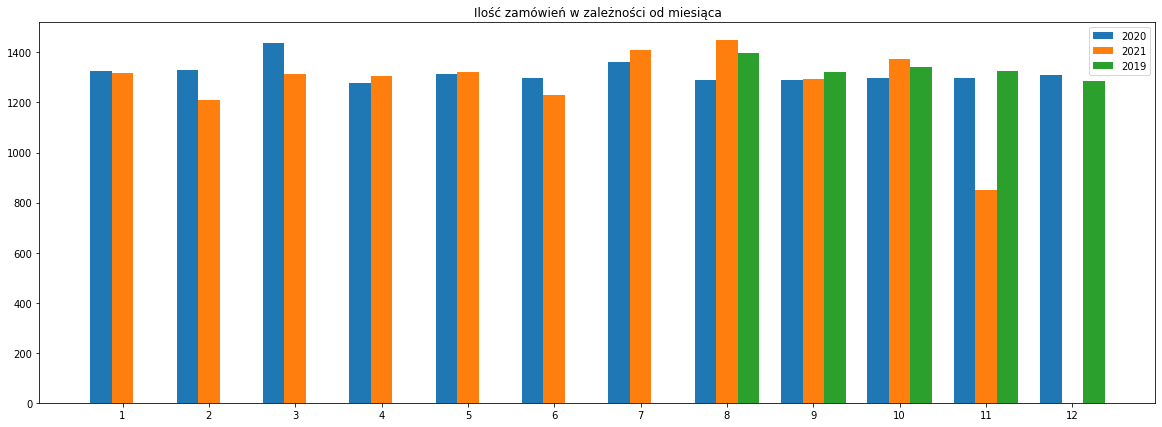

In [8]:
years = delivery_df["purchase_timestamp"].dt.year.value_counts().to_dict().keys()
months = range(1, 13)

df_list = []
for index, year in enumerate(years):
    delivery_year =  delivery_df[delivery_df.purchase_timestamp.dt.year.eq(year)]
    df = delivery_year.groupby(delivery_year["purchase_timestamp"].dt.month)["purchase_timestamp"].count().to_dict()
    
    for num_month in months:
        if num_month not in df.keys(): 
            df[num_month] = 0 
            
    df_list.append([j for _,j in sorted(df.items())])


show_plot_for_years(years, months, df_list, "Ilość zamówień w zależności od miesiąca")

###  Ilość zamówień z danej kategorii

In [9]:
purchase_from_category_df = pd.merge(sessions_df[sessions_df['event_type'] == "BUY_PRODUCT"], product_df, on='product_id', how='inner')
purchase_from_category_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,2019-12-30 21:46:44,112,1029,BUY_PRODUCT,20,20001.0,Tom Clancy&#39;s Rainbow Six Vegas 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
1,2019-09-18 21:13:41,1091,1029,BUY_PRODUCT,5,22451.0,Tom Clancy&#39;s Rainbow Six Vegas 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
2,2019-10-21 04:49:39,582,1029,BUY_PRODUCT,10,23811.0,Tom Clancy&#39;s Rainbow Six Vegas 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
3,2019-10-31 06:11:17,754,1029,BUY_PRODUCT,10,24178.0,Tom Clancy&#39;s Rainbow Six Vegas 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,2019-12-23 15:14:39,1057,1029,BUY_PRODUCT,0,26658.0,Tom Clancy&#39;s Rainbow Six Vegas 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
...,...,...,...,...,...,...,...,...,...
36569,2021-04-04 10:38:41,815,1147,BUY_PRODUCT,15,46307.0,Kurczak Mały (PC),Gry i konsole;Gry komputerowe,19.99
36570,2021-07-25 18:39:01,633,1147,BUY_PRODUCT,0,51023.0,Kurczak Mały (PC),Gry i konsole;Gry komputerowe,19.99
36571,2021-07-20 11:48:11,652,1147,BUY_PRODUCT,20,51026.0,Kurczak Mały (PC),Gry i konsole;Gry komputerowe,19.99
36572,2021-08-18 03:39:49,524,1147,BUY_PRODUCT,0,52338.0,Kurczak Mały (PC),Gry i konsole;Gry komputerowe,19.99


<AxesSubplot:xlabel='category_path'>

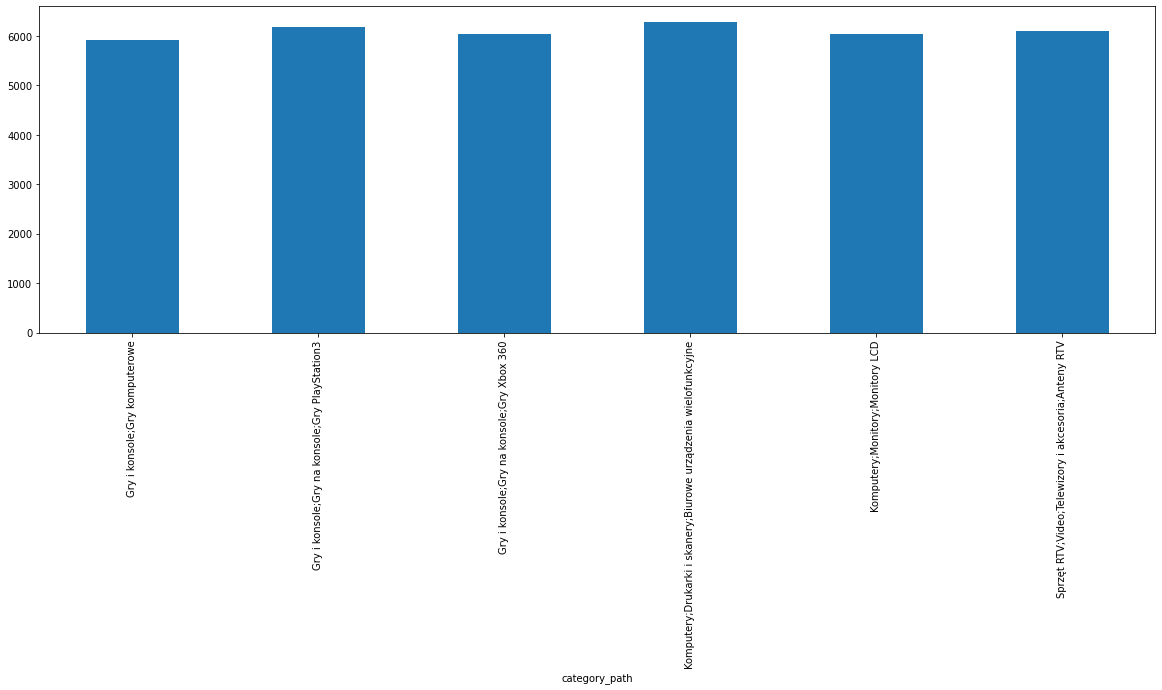

In [ ]:
fig, axs = plt.subplots(figsize=(20, 6))
purchase_from_category_df.groupby(purchase_from_category_df["category_path"])["category_path"].count().plot(kind='bar', rot=90, ax=axs)

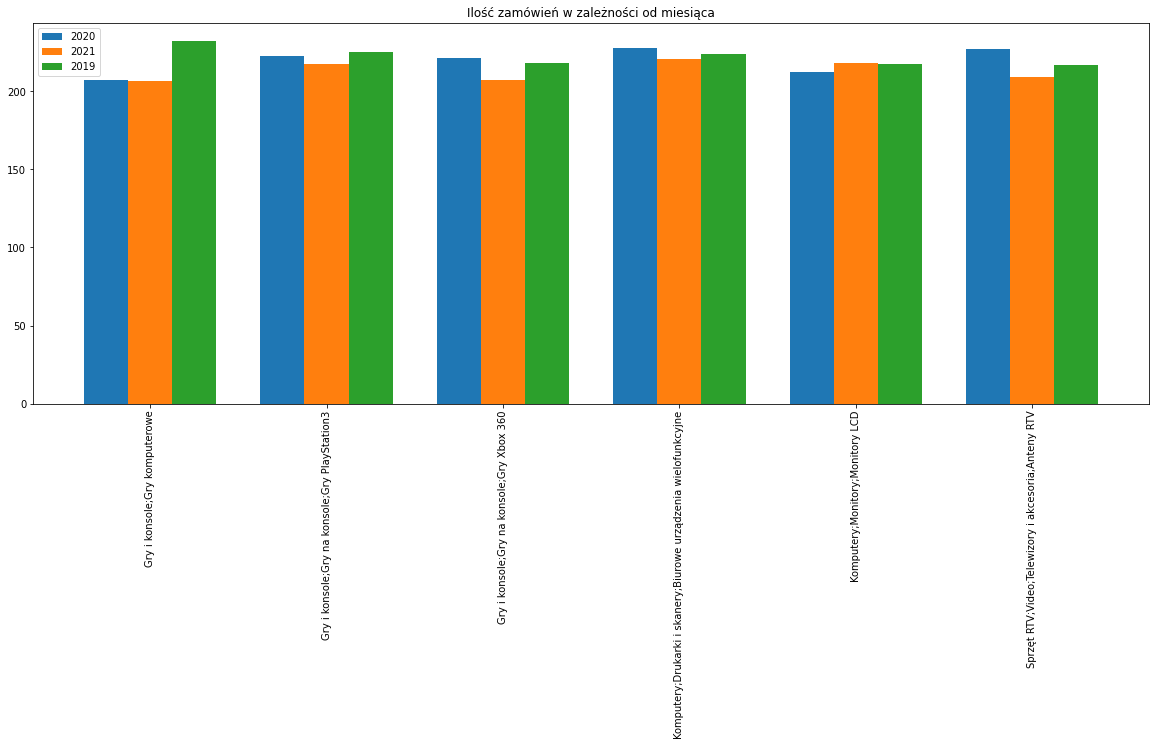

In [11]:
years = purchase_from_category_df["timestamp"].dt.year.value_counts().to_dict().keys()
categories = purchase_from_category_df.groupby(purchase_from_category_df["category_path"])["category_path"].count().to_dict().keys()
df_list = []
for index, year in enumerate(years):
    purchase_from_category_year = purchase_from_category_df[purchase_from_category_df.timestamp.dt.year.eq(year)]
    df = purchase_from_category_year.groupby(purchase_from_category_year["category_path"])["category_path"].count().to_dict()
    month_amount = len(purchase_from_category_year.groupby(purchase_from_category_year['timestamp'].dt.month)["timestamp"].count())
    df = dict(sorted(df.items())).values()
    df_list.append(np.divide(list(df), month_amount))

show_plot_for_years(years, categories, df_list, "Ilość zamówień w zależności od miesiąca", rotation=90)

### Ilość zamówień w danych przedziałach cenowych

In [ ]:
bought_product_df = sessions_df[sessions_df['event_type'] == "BUY_PRODUCT"]
bought_product_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
session_id,,,,,,
124,2019-12-30 21:46:44,112,1029,BUY_PRODUCT,20,20001.0
125,2019-12-30 02:49:32,120,1025,BUY_PRODUCT,15,20002.0
126,2019-12-30 21:11:21,120,1076,BUY_PRODUCT,0,20003.0
129,2019-12-30 05:43:49,125,1003,BUY_PRODUCT,0,20004.0
130,2019-12-31 11:34:04,175,1053,BUY_PRODUCT,0,20005.0
...,...,...,...,...,...,...
50657,2021-01-01 18:24:54,1046,1049,BUY_PRODUCT,0,56570.0
50658,2021-01-01 07:22:01,1051,1002,BUY_PRODUCT,5,56571.0
50660,2021-01-03 12:22:14,1061,1004,BUY_PRODUCT,15,56572.0


In [ ]:
df = pd.merge(bought_product_df, product_df, on='product_id', how='inner')
df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,product_name,category_path,price
0,2019-12-30 21:46:44,112,1029,BUY_PRODUCT,20,20001.0,Tom Clancy&#39;s Rainbow Six Vegas 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
1,2019-09-18 21:13:41,1091,1029,BUY_PRODUCT,5,22451.0,Tom Clancy&#39;s Rainbow Six Vegas 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
2,2019-10-21 04:49:39,582,1029,BUY_PRODUCT,10,23811.0,Tom Clancy&#39;s Rainbow Six Vegas 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
3,2019-10-31 06:11:17,754,1029,BUY_PRODUCT,10,24178.0,Tom Clancy&#39;s Rainbow Six Vegas 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,2019-12-23 15:14:39,1057,1029,BUY_PRODUCT,0,26658.0,Tom Clancy&#39;s Rainbow Six Vegas 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
...,...,...,...,...,...,...,...,...,...
36569,2021-04-04 10:38:41,815,1147,BUY_PRODUCT,15,46307.0,Kurczak Mały (PC),Gry i konsole;Gry komputerowe,19.99
36570,2021-07-25 18:39:01,633,1147,BUY_PRODUCT,0,51023.0,Kurczak Mały (PC),Gry i konsole;Gry komputerowe,19.99
36571,2021-07-20 11:48:11,652,1147,BUY_PRODUCT,20,51026.0,Kurczak Mały (PC),Gry i konsole;Gry komputerowe,19.99
36572,2021-08-18 03:39:49,524,1147,BUY_PRODUCT,0,52338.0,Kurczak Mały (PC),Gry i konsole;Gry komputerowe,19.99


         price
price         
129.00    2130
79.90     2007
49.99     1702
89.99     1510
69.00     1186
59.90     1167
5301.90   1143
32.99      956
7639.00    828
59.99      820


<AxesSubplot:>

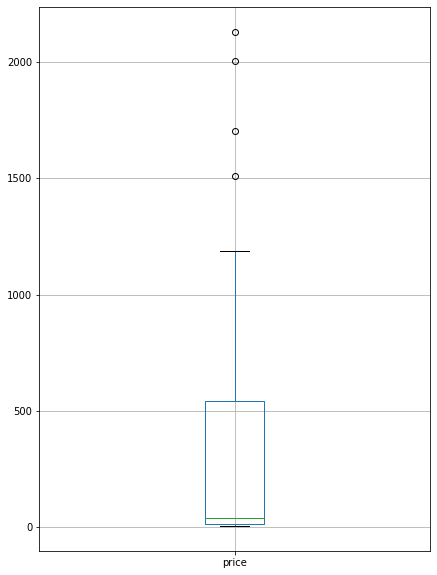

In [ ]:
bought_product_df = sessions_df[sessions_df['event_type'] == "BUY_PRODUCT"]
bought_product_df = bought_product_df.replace([np.inf, -np.inf], np.nan)
bought_product_df = bought_product_df.dropna()
df = pd.merge(bought_product_df, product_df, on='product_id', how='inner')
df = df.groupby(df["price"])["price"].count().to_frame()
print(df.nlargest(10, 'price'))
plt.figure(figsize = ( 7 , 10 ))
df.boxplot("price")

In [ ]:
user_activity = sessions_df[["event_type", "timestamp"]].copy()
user_activity["month"] = pd.DatetimeIndex(user_activity["timestamp"]).month
user_activity["day"] = pd.DatetimeIndex(user_activity["timestamp"]).day
user_activity["date"] = pd.DatetimeIndex(user_activity["timestamp"]).date

user_activity

,event_type,timestamp,month,day,date
session_id,,,,,
124,VIEW_PRODUCT,2019-12-30 21:43:37,12,30,2019-12-30
124,VIEW_PRODUCT,2019-12-30 21:45:51,12,30,2019-12-30
124,BUY_PRODUCT,2019-12-30 21:46:44,12,30,2019-12-30
125,VIEW_PRODUCT,2019-12-30 02:19:45,12,30,2019-12-30
125,VIEW_PRODUCT,2019-12-30 02:23:09,12,30,2019-12-30
...,...,...,...,...,...
50663,VIEW_PRODUCT,2021-01-01 09:22:40,1,1,2021-01-01
50663,VIEW_PRODUCT,2021-01-01 09:24:53,1,1,2021-01-01
50663,VIEW_PRODUCT,2021-01-01 09:28:29,1,1,2021-01-01


<AxesSubplot:xlabel='month'>

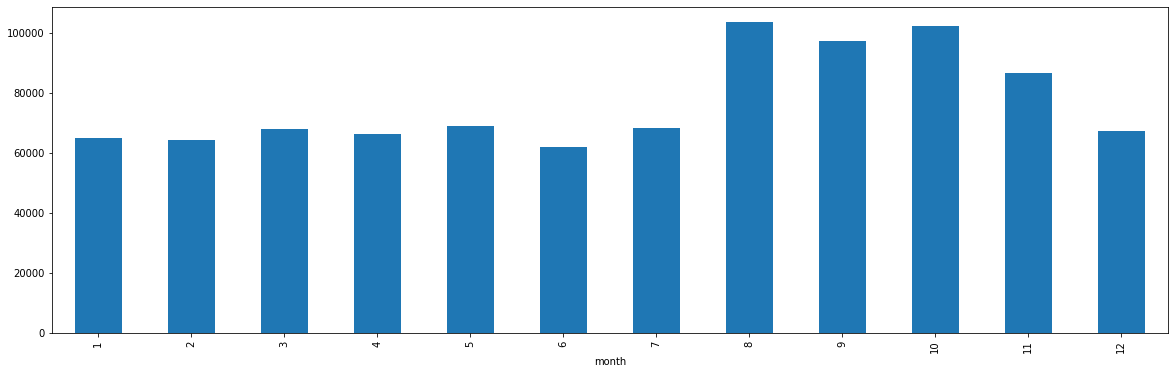

In [ ]:
fig, axs = plt.subplots(figsize=(20, 6))
user_activity.groupby(user_activity["month"])["month"].count().plot(kind='bar', ax=axs) 

<AxesSubplot:xlabel='day'>

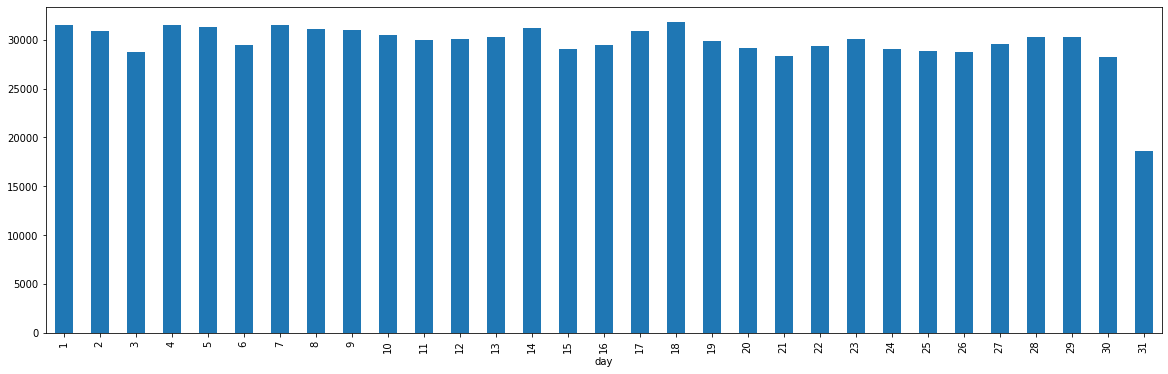

In [ ]:
fig, axs = plt.subplots(figsize=(20, 6))
user_activity.groupby(user_activity["day"])["day"].count().plot(kind='bar', ax=axs) 

            date
date            
2019-08-13  1942
2020-05-18  1839
2021-10-30  1807
2021-05-30  1804
2021-01-29  1773
2021-11-04  1769
2020-11-12  1763
2019-09-30  1707
2019-10-30  1675
2021-02-07  1671
2020-01-27  1614
2021-09-02  1601
2020-12-20  1571
2021-10-22  1567
2021-02-14  1548
2020-10-01  1547
2021-04-28  1547
2021-10-28  1545
2019-08-17  1544
2020-05-17  1537
2019-10-31  1527
2021-05-27  1513
2021-02-04  1511
2021-07-13  1505
2021-03-30  1503
2021-10-18  1502
2020-07-19  1497
2019-09-12  1495
2021-05-26  1493
2021-05-31  1487


<AxesSubplot:>

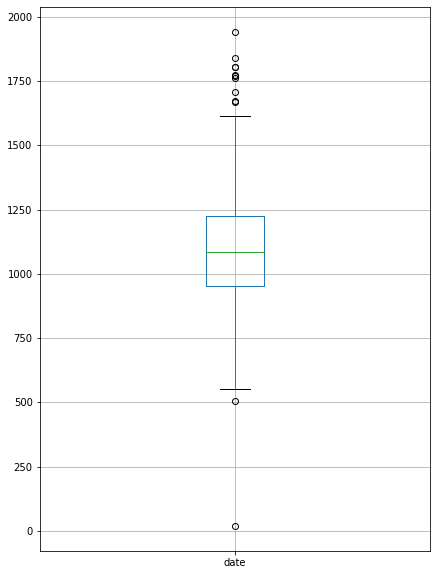

In [ ]:
df = user_activity.groupby(user_activity["date"])["date"].count().to_frame()
print(df.nlargest(30, 'date'))
plt.figure(figsize = ( 7 , 10 ))
df.boxplot("date")

<AxesSubplot:xlabel='offered_discount'>

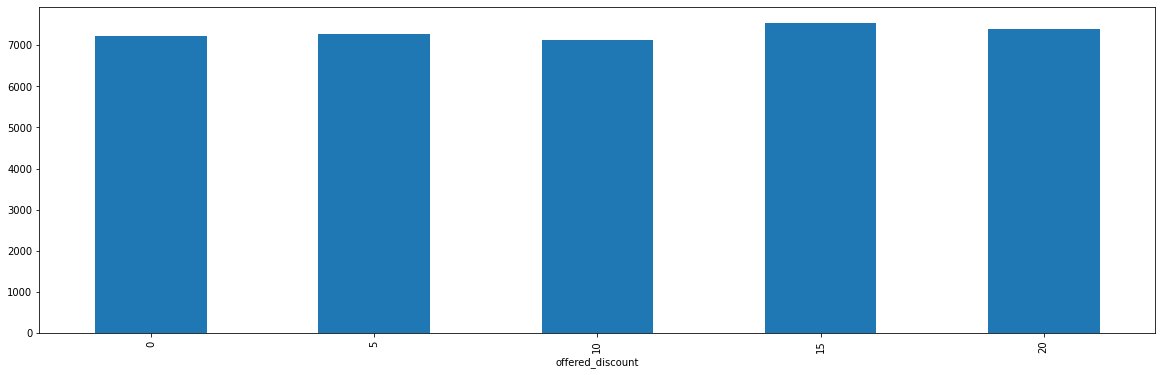

In [ ]:
fig, axs = plt.subplots(figsize=(20, 6))
bought_product_df.groupby(bought_product_df["offered_discount"])["offered_discount"].count().plot(kind='bar', ax=axs) 

In [ ]:
sessions_df

,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
session_id,,,,,,
124,2019-12-30 21:43:37,112,1012,VIEW_PRODUCT,20,NaN
124,2019-12-30 21:45:51,112,1029,VIEW_PRODUCT,20,NaN
124,2019-12-30 21:46:44,112,1029,BUY_PRODUCT,20,20001.0
125,2019-12-30 02:19:45,120,1071,VIEW_PRODUCT,15,NaN
125,2019-12-30 02:23:09,120,1017,VIEW_PRODUCT,15,NaN
...,...,...,...,...,...,...
50663,2021-01-01 09:22:40,1097,1129,VIEW_PRODUCT,20,NaN
50663,2021-01-01 09:24:53,1097,1130,VIEW_PRODUCT,20,NaN
50663,2021-01-01 09:28:29,1097,1019,VIEW_PRODUCT,20,NaN


In [ ]:
df = pd.merge(sessions_df, product_df, on='product_id', how='inner')

<AxesSubplot:xlabel='category_path'>

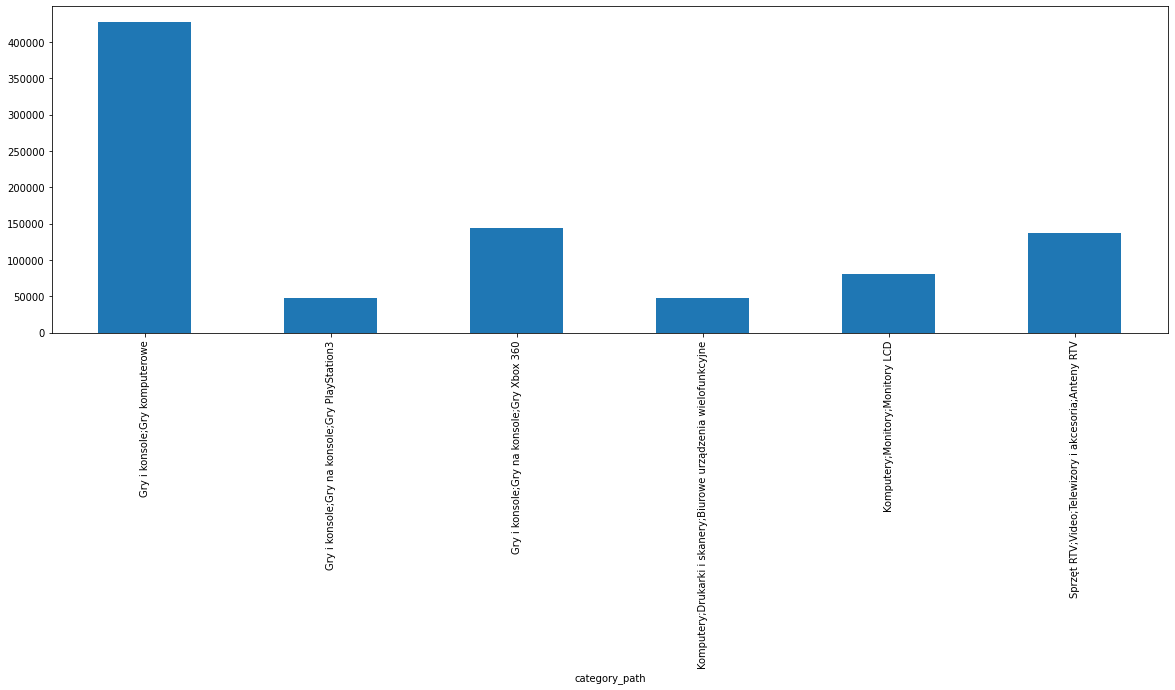

In [ ]:
fig, axs = plt.subplots(figsize=(20, 6))
df[df["event_type"] == "VIEW_PRODUCT"].groupby('category_path')["category_path"].count().plot(kind='bar', ax=axs) 


<AxesSubplot:xlabel='category_path'>

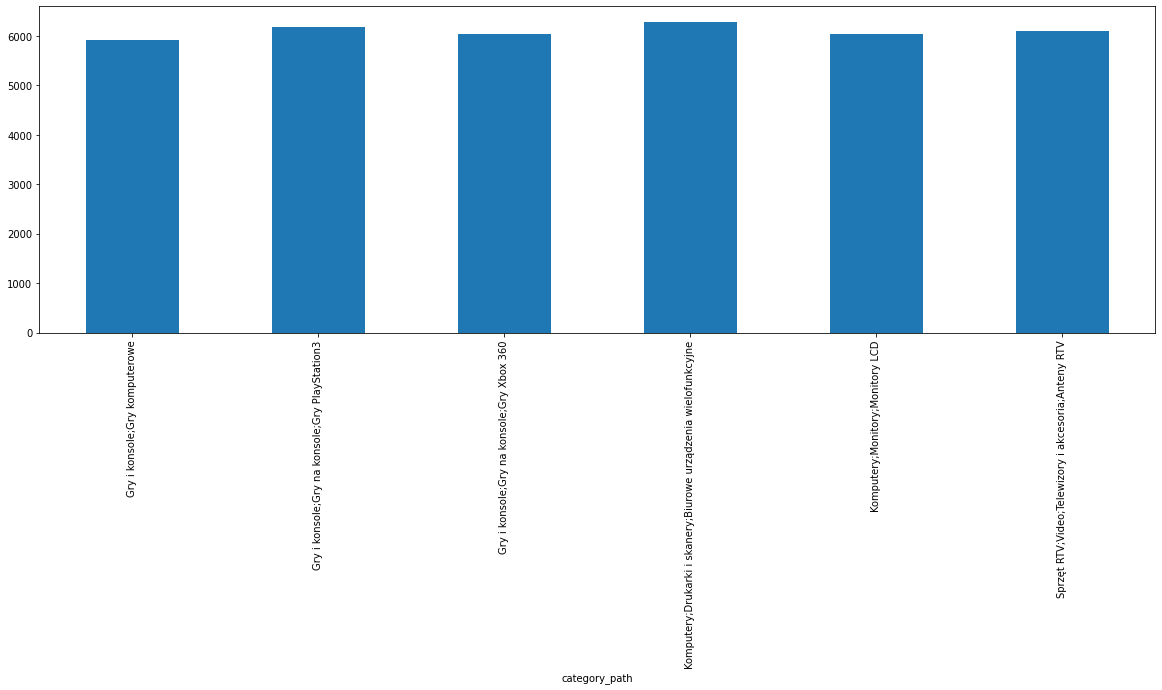

In [ ]:
fig, axs = plt.subplots(figsize=(20, 6))
df[df["event_type"] == "BUY_PRODUCT"].groupby('category_path')["category_path"].count().plot(kind='bar', ax=axs) 